# STATS 607
## Week 3: Automatic differentiation

## Computing derviatives

- In statistical inference, we often need to navigate to the (local) minimum/maximum of a function:
    - Least squares: $\min_\beta \| X\beta - y \|$
    - MLE: $\max \log p(x\mid \theta)$
    - Method of moments: $\min_\theta \| \hat{m} - m(\theta) \|$
    - Bayesian: sample around the mode of $p(\theta \mid x)$

- To do this efficiently, we need to know about the _geometry_ of a function. 
- "Which way is up?"
    

## Methods to compute derivatives
- By hand (calculus)
- Symbolically
- Numerically
- **Automatically**

## Example function

$$f(x, y) = x y + \sin(x)$$

### By hand

From calculus we know that

\begin{align}
\partial f / \partial x &= y + \cos (x) \\
\partial f / \partial y &= x
\end{align}

But this won't work for even moderately complicated functions. You are bound to make an error!

### Symbolically

Use a symbolic algebra progam to compute the derivatives:

In [322]:
import sympy
x, y = sympy.var('x y')
f = x * y + sympy.sin(x); f

x*y + sin(x)

In [323]:
sympy.diff(f, x)

y + cos(x)

- Symbolic differentiation quickly runs into "expression creep". 
- Logistic map: 
    - $\ell_1 = x$ 
    - $\ell_{n+1} = 4 \ell_n (1 - \ell_n)$

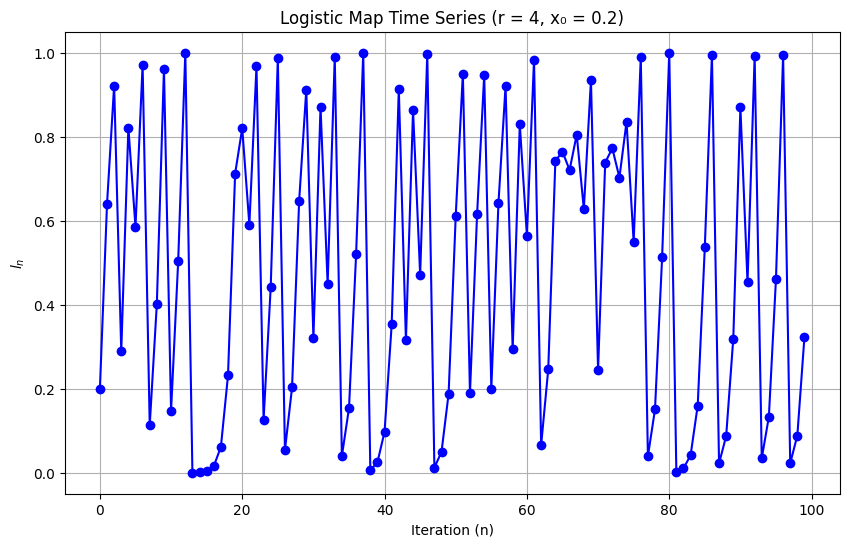

In [331]:
def logistic_map(r, x):
    return r * x * (1 - x)

# Parameters for the time series plot
r = 4
x0 = 0.2  # Initial value (0 < x0 < 1)
n_iterations = 100

# Initialize array to store the values
x_values = np.zeros(n_iterations)
x_values[0] = x0

# Iterate the logistic map
for i in range(1, n_iterations):
    x_values[i] = logistic_map(r, x_values[i - 1])

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), x_values, marker='o', linestyle='-', color='blue')
plt.title(f'Logistic Map Time Series (r = {r}, x₀ = {x0})')
plt.xlabel('Iteration (n)')
plt.ylabel('$l_n$')
plt.grid(True)
plt.show()

In [332]:
def ell(n):
    if n == 1:
        return x
    eln = ell(n - 1)
    return 4 * eln * (1 - eln)

sympy.diff(ell(5), x)

256*x*(1 - x)*(8*x - 4)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1) + 256*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(8*x - 4)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) - 64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(8*x - 4) + 16*x*(-4*x*(1 - x) + 1) - 16*(1 - x)*(-4*x*(1 - x) + 1)) + 64*x*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) - 64*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)) + 256*x*(1 - x)*(-4*x*(1 - x) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1)*(-16*x*(1 - x)*(8*x - 4) + 16*x*(-4*x*(1 - x) + 1) - 16*(1 - x)*(-4*x*(1 - x) + 1)) - 256*x*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1) + 1) + 256*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*x*(1 - x) + 1) + 1)*(-64*x*(1 - x)*(-4*x*(1 - x) + 1)*(-16*x*(1 - x)*(-4*

### Numerical differentiation

- Uses finite differences to approximate the derivative:

  $$f'(x) \approx \frac{f(x + h) - f(x)}{h}$$
    
  for very small $h$.

- Disadvantages:
    - Costs $\mathcal{O}(d)$ when $x \in \mathbb{R}^d$.
    - Potentially inaccurate: approximation error ($h$ too large); underflow ($h$ too small).

In [364]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return 64 * x * (1 - x) * (1 - 2 * x)**2 * (1 - 8 * x + 8 * x**2)**2

df_exact = sympy.lambdify(x, f(x).diff(x))

Text(0, 0.5, 'Error')

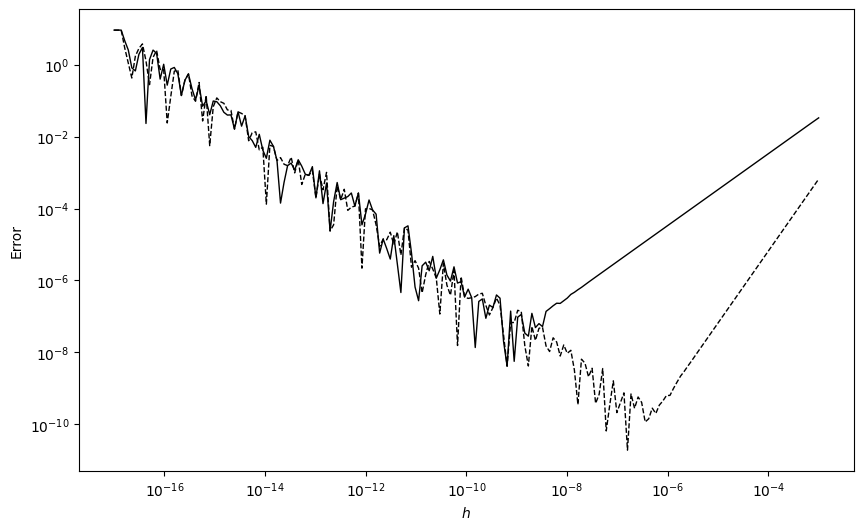

In [373]:
x0 = 0.2
h = np.logspace(-17, -3, 200)

df_fwd = (f(x0 + h) - f(x0)) / h
df_cen = (f(x0 + h) - f(x0 - h)) / 2 / h
err_fwd = abs(df_fwd - df_exact(x0))
err_cen = abs(df_cen - df_exact(x0))

plt.figure(figsize=(10, 6))
plt.loglog(h, err_fwd, label='Forward difference', color='black', linewidth=1)
plt.loglog(h, err_cen, '--', label='Center difference', color='black', linewidth=1)
plt.xlabel('$h$')
plt.ylabel('Error')

## Forward mode AD
- Forward mode autodiff essentially automates the process you learned in calculus. 
- Let's differentiate $z = x y + \sin(x)$. 
- The computer sees this as:

      x = <input>
      y = <input>
      a = x * y
      b = sin(x)
      z = a * b

- Now let's consider differentiating with respect to some input variable $t$. 
- We differentiate each step of the program with respect to $t$:

\begin{align}
\frac{\partial x}{\partial t} &= {?} \\
\frac{\partial y}{\partial t} &= {?} \\
\frac{\partial a}{\partial t} &= y \cdot \frac{\partial x}{\partial t} + x \cdot \frac{\partial y}{\partial t} \\
\frac{\partial b}{\partial t} &= \cos(x) \cdot \frac{\partial x}{\partial t} \\
\frac{\partial z}{\partial t} &= \frac{\partial a}{\partial t} + \frac{\partial b}{\partial t}
\end{align}
    

- Substituting $t=x$, we get $\partial x/\partial x=1$, $\partial y/\partial x=0$, and all the other partials are determined.
- Similarly for $t=y$.
- We can automatically translate the above function into one that computes derivatives:

        dx = ?
        dy = ?
        da = y * dx + x * dy
        db = cos(x) * dx
        dz = da + db

In fact, we can simply interleave the two, in order to compute the function value and the derivative value at the same time:

      x = ?
      dx = ?
      y = ?
      dy = ?
      a = x * y
      da = x * dy + y * dx
      b = sin(x)
      db = cos(x) * dx
      dz = da * b + a * db 

Let's implement a simple forward-mode autodiff class using operator overloading:

In [375]:
from dataclasses import dataclass

@dataclass
class Number:
    x: float
    dx: float = 0.
        
Number(1.)

Number(x=1.0, dx=0.0)

In [376]:
Number(1.) + Number(1.)

TypeError: unsupported operand type(s) for +: 'Number' and 'Number'

In [377]:
def _add(a: Number, b: Number) -> Number:
    return Number(a.x + b.x, a.dx + b.dx)
    
Number.__add__ = _add

Number(1.) + Number(1.)

Number(x=2.0, dx=0.0)

In [378]:
Number(1.) * Number(2.)

TypeError: unsupported operand type(s) for *: 'Number' and 'Number'

In [379]:
def _mul(a: Number, b: Number) -> Number:
    return Number(a.x * b.x, a.dx * b.x + b.dx * a.x)
    
Number.__mul__ = _mul

In [390]:
import math

def sin(a: Number) -> Number:
    return Number(a.x, -a.dx * math.sin(a.x))

def cos(a: Number) -> Number:
    return Number(a.x, -a.dx * math.sin(a.x))

Now let's return to our function:

$$f(x,y) = xy + \cos(x)$$


In [385]:
def f(x, y):
    return x * y + sin(x)




Let's compute $\nabla f_{x=2,y=1}$ in four ways:
- by hand
- using symbolic differentiation
- using numerical differentiation
- using forward-mode autodiff

By hand:
- $\partial f/\partial x = y + \sin(x)$
- $\partial f/\partial y = x$

In [388]:
def df(x, y):
    return (y - math.sin(x), x)

df(2., 1.)

(0.09070257317431829, 2.0)

Using symbolic differentiation:

In [381]:
import sympy
x, y = sympy.var('x y')

sympy.diff(x*y + sympy.cos(x), x)

y - sin(x)

Using numerical differentiation:

In [389]:
scipy.optimize.approx_fprime((2., 1.,), lambda xy: xy[0] * xy[1] + np.sin(xy[0]))

array([0.58385313, 2.        ])

In [382]:
Using dual numbers/forward mode:

SyntaxError: invalid syntax (1108314070.py, line 1)

In [56]:
x = Number(2., 0.)
y = Number(1., 1.)

f(x, y)

Number(x=4.0, dx=2.0)

Adding some more methods:

In [182]:
def _div(a: Number, b: Number):
    return Number(a.x / b.x, (a.dx * b.x - a.x * b.dx) / b.x ** 2)

Number.__truediv__ = _div

def _pow(a: Number, n: int):
    assert isinstance(n, int)
    return Number(a.x ** n, n * a.x ** (n - 1) * a.dx)

Number.__pow__ = _pow

The last example has an unfortunate consequence: something as simple as `Number(1.) ** 2` will throw:

In [184]:
Number(2., 3.) ** 2

Number(x=4.0, dx=12.0)

We can extend our class in various ways. For example, we can make it play nicely with normal Python numbers:

In [202]:
def numbify(f):
    def g(*args):
        nargs = []
        for a in args:
            if isinstance(a, (float, int)):
                a = Number(a, 0.)
            assert isinstance(a, Number)
            nargs.append(a)
        return f(*nargs)
    return g
    
Number.__mul__ = Number.__rmul__ = numbify(_mul)
Number.__add__ = numbify(_add)
Number.__radd__ = Number.__add__
Number.__sub__ = lambda a, b: a + (-b)
Number.__truediv__ = numbify(_div)
Number.__pow__ = _pow

In [203]:
8 + Number(2.)

Number(x=10.0, dx=0.0)

In [194]:
@numbify
def exp(a: Number):
    y = math.exp(a.x)
    return Number(y, y * a.dx)

@numbify

def log(a: Number):
    return Number(math.log(a.x), a.dx / a.x)

In [195]:
def grad(f):
    def g(*args):
        ret = []
        for i, a in enumerate(args):
            aargs = args[:i] + (Number(args[i], 1.),) + args[i + 1:]
            ret.append(f(*aargs).dx)
        return ret
    return g

In [196]:
@grad
def f(x, y):
    return x * y + exp(x)

f(2., 1.)

[8.38905609893065, 2.0]

Let's use our code to maximize the following function:

In [212]:
def f(x, y):
    return np.exp(-(x**2 + (y + 1)**2)) + 2 * np.exp(-((x - 3)**2 + y**2))

In [162]:
import numpy as np
# Create a grid of x and y values
x = np.linspace(-5, 8, 300)
y = np.linspace(-5, 5, 300)
X, Y = np.meshgrid(x, y)

# Compute the function values on the grid
Z = f(X, Y)

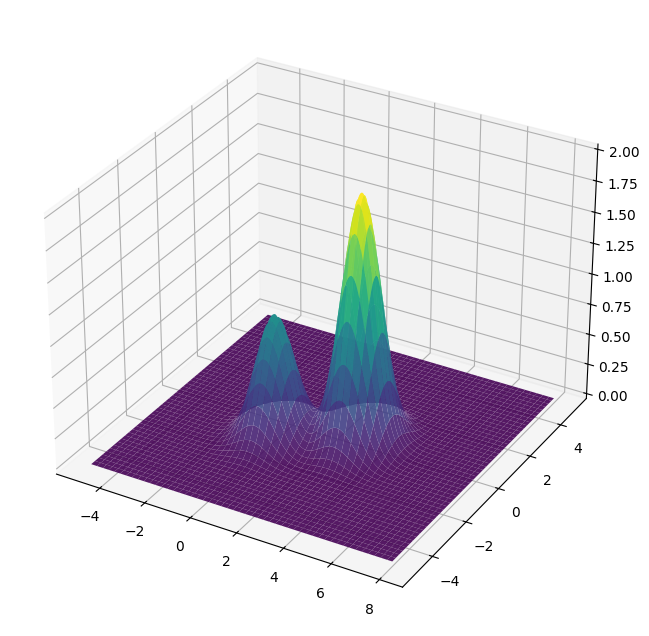

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

In [213]:
import scipy.optimize

scipy.optimize.minimize(lambda x: -f(x[0], x[1]), np.random.rand(2))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.0000908824458488
        x: [ 2.730e-04 -9.999e-01]
      nit: 4
      jac: [ 3.129e-07  3.085e-06]
 hess_inv: [[ 5.009e-01  4.295e-04]
            [ 4.295e-04  5.017e-01]]
     nfev: 30
     njev: 10

In [214]:
def g(t):
    x, y = t
    
    def h(x, y):
        return -(exp(-(x**2 + (y + 1)**2)) + 2 * exp(-((x - 3)**2 + y**2)))
    
    
    return h(x, y).x, grad(h)(x, y)

g([1., 1.])

(-0.0202138409972564, [-0.0404276819945128, 0.053903575992683736])

In [215]:
scipy.optimize.minimize(g, np.random.rand(2), jac=True)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.0000908824482304
        x: [ 2.728e-04 -9.999e-01]
      nit: 9
      jac: [-7.996e-08  3.740e-08]
 hess_inv: [[ 5.091e-01 -3.621e-03]
            [-3.621e-03  5.019e-01]]
     nfev: 17
     njev: 17

## Reverse mode autodiff

- In reverse mode autodiff, we reverse the order in which the partial derivatives are accumulated.

![reverse mode ad](https://rufflewind.com/img/reverse-mode-automatic-differentiation-graph.png)

Let's see how this works for the simple function defined above. For an as-yet-to-be-determined variable $s$, we have:

\begin{align}
\frac{\partial s}{\partial z} &= {?}  \\
\frac{\partial s}{\partial b} &= \frac{\partial s}{\partial z} \\
\frac{\partial s}{\partial a} &= \frac{\partial s}{\partial z} \\
\frac{\partial s}{\partial y} &= x \cdot \frac{\partial s}{\partial a} \\
\frac{\partial s}{\partial x} &= y \cdot \frac{\partial s}{\partial a} + \cos(x) \cdot \frac{\partial s}{\partial b}
\end{align}

Translating this into code, we get:
    
    gz = ?
    gb = gz
    ga = gz
    gy = x * ga
    gx = y * ga + cos(x) * gb
    
The variables `gz`$=\partial{z}/\partial{s}$ are referred to as `adjoint` variables.

In [316]:
from dataclasses import field 

@dataclass
class Node:
    x: float
    children: list[(float, 'Node')] = field(default_factory=list)
    _grad: float = None

In [301]:
def _add_T(a: Node, b: Node):
    z = Node(a.x + b.x)
    a.children.append((1., z))
    b.children.append((1., z))
    return z

Node.__add__ = _add_T

In [302]:
def grad(self):
    if self._grad is None:
        self._grad = sum(w * c.grad() for w, c in self.children)
    return self._grad
    

Node.grad = grad

In [303]:
a = Node(1)
b = Node(2)
x = a + b
x._grad = 1

In [304]:
b.grad()

1.0

In [305]:
def _mul_T(a: Node, b: Node):
    z = Node(a.x * b.x)
    a.children.append((b.x, z))
    b.children.append((a.x, z))
    return z

Node.__mul__ = _mul_T

In [306]:
a = Node(1)
b = Node(2)
x = a * b
x._grad = 1
b.grad()

1

In [313]:
def sin_T(a: Node):
    z = Node(math.sin(a.x))
    a.children.append((math.cos(a.x), z))
    return z

In [314]:
a = Node(2)
b = Node(1)
x = a * b + sin_T(a)
x._grad = 1
a.grad()

0.5838531634528576